In [1]:
import scanpy as sc
import pandas as pd
from pathlib import Path
import anndata as ad
import numpy as np
import scvi

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

DPI = 300
FONTSIZE = 20  # 42

sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

Global seed set to 0


In [2]:
scvi.__version__

'0.16.4'

In [2]:
DIR2SAVE = Path("/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/20mt/data_integration/")

In [3]:
FIG2SAVE = DIR2SAVE.joinpath("figures/")
FIG2SAVE
# set the global variable: sc.settings.figdir to save all plots
sc.settings.figdir = FIG2SAVE

In [4]:
DIR2SAVE.mkdir(parents=True, exist_ok=True)
FIG2SAVE.mkdir(parents=True, exist_ok=True)

### Load raw data 

In [5]:
adata_crc = sc.read_h5ad(DIR2SAVE.joinpath("SMC_KUL_Pelka_Che_Wu_CRC_raw.h5ad"))

In [6]:
adata_crc.shape

(328063, 39609)

### Normalise + log transform + HVG

Up to this point the data is only available as a count matrix. Counts are representative of molecules that were captured in the scRNA-seq experiment. As not all mRNA molecules in a cell are captured, there is a variability in the total number of counts detected between cells that results from both the number of molecules that were in the cells, and the sampling. As we cannot assume that all cells contain an equal number of molecules (cell sizes can differ substantially), we have to estimate the number of molecules that were initially in the cells. In fact, we don't estimate the exact number of molecules, but instead estimate cell-specific factors that should be proportional to the true number of molecules. These are called size factors. Normalized expression values are calculated by dividing the measured counts by the size factor for the cell.

The basic preprocessing includes assuming all size factors are equal (library size normalization to counts per million - CPM) and log-transforming the count data.


In [7]:
# keep raw
adata_crc.layers["raw"] = adata_crc.X.copy()  # preserve counts

# normalize + log1p
sc.pp.normalize_total(adata_crc, target_sum=1e4, inplace=True)
adata_crc.layers["normalised"] = adata_crc.X.copy()
sc.pp.log1p(adata_crc)

adata_crc.layers["log1p"] = adata_crc.X.copy()

The count data has been normalized and log-transforme d with an offset of 1. The latter is performed to normalize the data distributions. The offset of 1 ensures that zero counts map to zeros. We keep this data in the '.raw' part of the AnnData object as it will be used to visualize gene expression and perform statistical tests such as computing marker genes for clusters.

In [8]:
adata_crc.raw = adata_crc  # keep normalised log1p

### HVG 
We extract highly variable genes (HVGs) to further reduce the dimensionality of the dataset and include only the most informative genes. Genes that vary substantially across the dataset are informative of the underlying biological variation in the data. HVGs are used for clustering, trajectory inference, and dimensionality reduction/visualization, while the full data set is used for computing marker genes, differential testing, cell cycle scoring, and visualizing expression values on the data.

**Expects logarithmized data, except when `flavor='seurat_v3'` in which
count data is expected.**

In [9]:
sc.pp.highly_variable_genes(
    adata_crc,
    subset=True,  # subset for integration (but full lognorm data in .raw)
    layer="raw",
    flavor="seurat_v3",
    n_top_genes=2000,
    span=0.3,
    min_disp=0.5,
    min_mean=0.0125,
    max_mean=3,
    batch_key="cell_source",
)

In [10]:
adata_crc.X.shape

(328063, 2000)

In [11]:
adata_crc.raw.to_adata().X.shape

(328063, 39609)

### scVI
Unless otherwise specified, scvi-tools models require the raw counts (not log library size normalized).

Now it’s time to run setup_anndata(), which alerts scvi-tools to the locations of various matrices inside the anndata. It’s important to run this function with the correct arguments so scvi-tools is notified that your dataset has batches, annotations, etc. For example, if batches are registered with scvi-tools, the subsequent model will correct for batch effects. See the full documentation for details.

In this dataset, there is a “cell_source” categorical covariate, and within each “cell_source”, multiple “patients”. There are also two continuous covariates we’d like to correct for: “percent_mito” and “percent_ribo”. These covariates can be registered using the categorical_covariate_keys argument. If you only have one categorical covariate, you can also use the batch_key argument instead.



In [12]:
scvi.model.SCVI.setup_anndata(
    adata_crc,
    layer="raw",
    categorical_covariate_keys=["cell_source", "Patient"],
    continuous_covariate_keys=[
        "pct_counts_mt",
        "pct_counts_ribo",
    ],  # here for cell cycle
)

#### Creating and training a model

In [13]:
model = scvi.model.SCVI(adata_crc)
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

In [14]:
model.train()

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - 

Epoch 24/24: 100%|██████████| 24/24 [09:20<00:00, 23.36s/it, loss=447, v_num=1]


In [15]:
DIR2SAVE

PosixPath('/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/20mt/data_integration')

In [16]:
# save model
import os

model.save(os.path.join(DIR2SAVE, "scvi_model_hvg_mt_ribo"))

In [17]:
# read the model
model = scvi.model.SCVI.load(
    os.path.join(DIR2SAVE, "scvi_model_hvg_mt_ribo"), adata=adata_crc
)  # , use_gpu=True)

INFO     File /data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/20mt/data_integration/scvi_m
         odel_hvg_mt_ribo/model.pt already downloaded                                        


In [18]:
latent = model.get_latent_representation()  # get model output

In [19]:
latent.shape

(328063, 10)

In [20]:
# It’s often useful to store the outputs of scvi-tools back into the original anndata, as it permits interoperability with
# Scanpy.
adata_crc.obsm["X_scVI"] = latent

In [21]:
# Let’s store the normalized values back in the anndata.
adata_crc.layers["scvi_normalized"] = model.get_normalized_expression(
    adata=adata_crc, library_size=1e4
)

In [22]:
# save to file
adata_crc.write(DIR2SAVE.joinpath("SMC_KUL_Pelka_Che_Wu_CRC_integrated_scvi_hvg.h5ad"))

### Visualization without batch correction

In [5]:
adata_crc = sc.read_h5ad(
    DIR2SAVE.joinpath("SMC_KUL_Pelka_Che_Wu_CRC_integrated_scvi_hvg.h5ad")
)

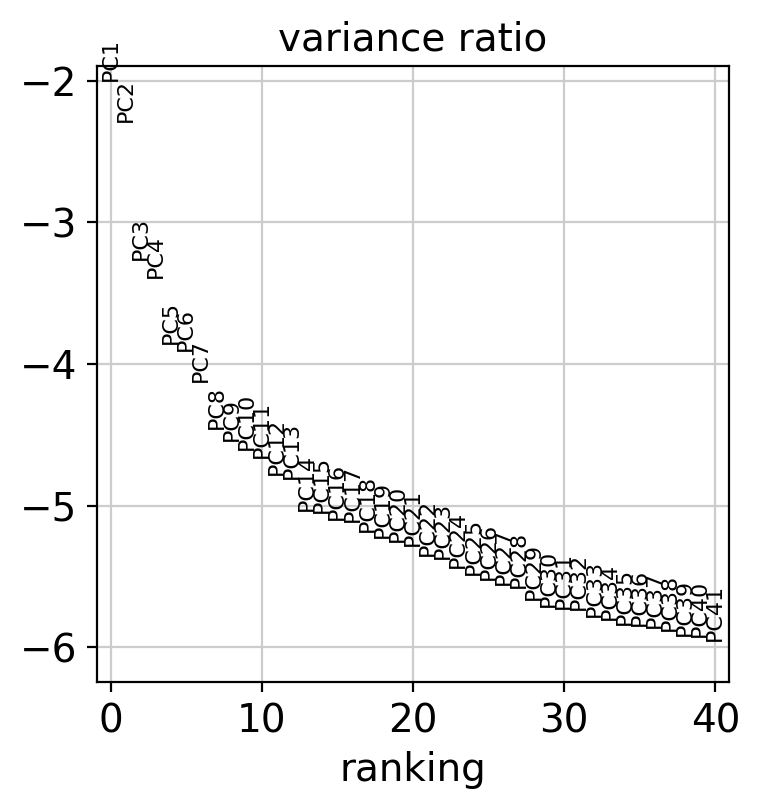

In [6]:
# perform PCA on adata_liver (which contains only HVG (after normalized, log1p) and scaled
sc.tl.pca(adata_crc, svd_solver="arpack", use_highly_variable=True, random_state=7)

# Elbow plot
sc.pl.pca_variance_ratio(adata_crc, log=True, n_pcs=40, show=True)

# compute neighbourhood graph
sc.pp.neighbors(
    adata_crc,
    n_neighbors=15,
    n_pcs=15,
    knn=True,
    method="umap",
    metric="euclidean",
    random_state=7,
)

# compute UMAP embedding
sc.tl.umap(adata_crc, min_dist=0.3, n_components=2, random_state=7)

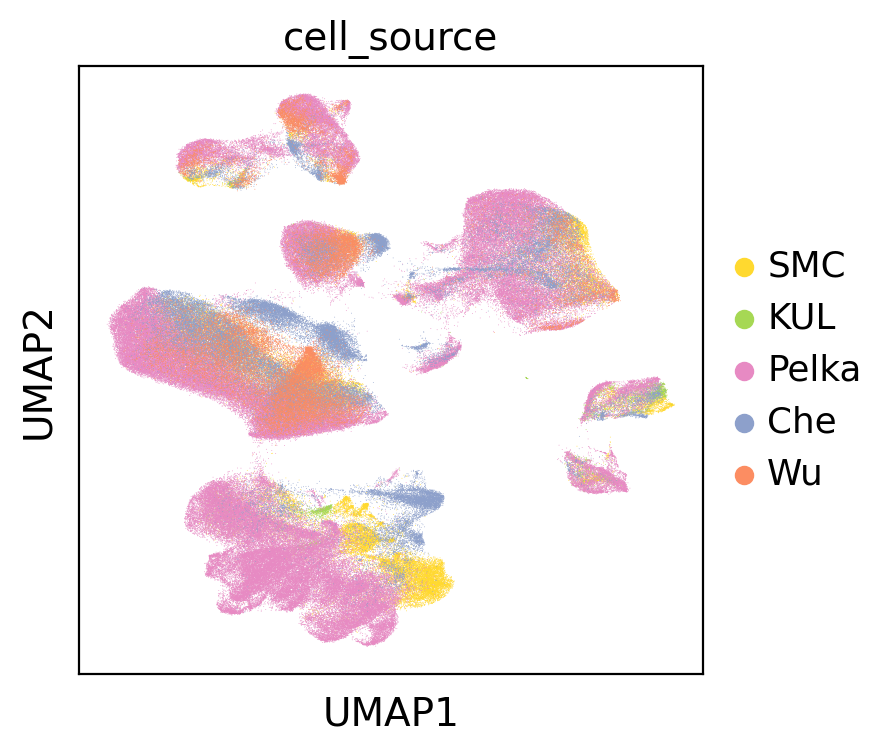

In [7]:
sc.pl.umap(
    adata_crc, color="cell_source", save="before_integration_scvi.pdf", show=True
)

In [8]:
# save to file
adata_crc.write(DIR2SAVE.joinpath("SMC_KUL_Pelka_Che_Wu_CRC_integrated_scvi_hvg.h5ad"))

### Cell cycle scoring 

In [5]:
adata_crc = sc.read_h5ad(
    DIR2SAVE.joinpath("SMC_KUL_Pelka_Che_Wu_CRC_integrated_scvi_hvg.h5ad")
)

In [6]:
def cell_cycle_scoring(adata, cc_genes_file, subtract=False, use_raw=True):
    """
    Computes cell cycle G2M and S phase scores using provided list
    :param adata: need log1p normalised data
    :param cc_genes_file: list of cell cycling genes (often list provided Macosko et al. 2015)
    :param subtract: compute the difference between the S and G2M scores
    :param use_raw: adata.raw where log1p norm is stored, by default True
    :return:
    """
    cc_genes = pd.read_csv(cc_genes_file)

    cc_genes = list(cc_genes["Cell_cycle_genes"])

    # select only cell cycle genes involved in phase S
    cc_genes_s = cc_genes[:43]
    # select only cell cycle genes involved in phase G2/M
    cc_genes_g2m = cc_genes[43:]

    # select cc_genes that are in our gene repertoire
    # isin is an element-wise function version of the python keyword in. isin(a, b) is roughly equivalent to
    # np.array([item in b for item in a]) if a and b are 1-D sequences.
    # cc_genes_s_var = adata.raw.to_adata().var_names[np.isin(adata.raw.to_adata().var_names, cc_genes_s)]
    # cc_genes_g2m_var = adata.raw.to_adata().var_names[np.in1d(adata.raw.to_adata(), cc_genes_g2m)]

    cc_genes_s_var = [
        ele for ele in cc_genes_s if ele in adata.raw.to_adata().var_names
    ]
    cc_genes_g2m_var = [
        ele for ele in cc_genes_g2m if ele in adata.raw.to_adata().var_names
    ]

    # to ensure reproducibility from issue https://github.com/theislab/scanpy/issues/313
    # adata.X = adata.X.astype('<f8')  # Make float64 to ensure stability

    sc.tl.score_genes_cell_cycle(
        adata,
        s_genes=cc_genes_s_var,
        g2m_genes=cc_genes_g2m_var,
        random_state=7,
        use_raw=use_raw,
    )

    if subtract:  # https://satijalab.org/seurat/archive/v3.0/cell_cycle_vignette.html
        # regressing out the difference between the G2M and S phase scores.
        # This means that signals separating non-cycling cells and cycling cells will be maintained,
        # but differences in cell cycle phase amongst proliferating cells (which are often uninteresting),
        # subtracting scores individually removes all signal associated with cell cycle but not always good.
        # Sometimes useful to try differences
        # particularly in differentiating processes (like murine hematopoiesis), where stem cells are quiescent
        # and differentiated cells are proliferating. Regressing out all cell cycle effects can blur the distinction
        # between stem and progenitor cells as well
        adata.obs["cell_cycle_diff"] = adata.obs["S_score"] - adata.obs["G2M_score"]
        # https://github.com/theislab/scanpy/issues/526

    # adata.X = adata.X.astype('<f4')  # Return to float32 for consistency

    return adata

In [7]:
cell_cycle_scoring(
    adata_crc,
    cc_genes_file="/data/BCI-CRC/nasrine/data/Tirosh2016_coreCellCycle.csv",
    subtract=True,
    use_raw=True,
)  # use log1p norm data

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


AnnData object with n_obs × n_vars = 328063 × 2000
    obs: 'Patient', 'Sample', 'Cell_type', 'Cell_subtype', 'Tissue', 'Therapy', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'cell_source', '_scvi_batch', '_scvi_labels', 'S_score', 'G2M_score', 'phase', 'cell_cycle_diff'
    var: 'n_cells_by_counts-Che', 'total_counts-Che', 'mean_counts-Che', 'pct_dropout_by_counts-Che', 'n_cells_by_counts-KUL', 'total_counts-KUL', 'mean_counts-KUL', 'pct_dropout_by_counts-KUL', 'n_cells_by_counts-Pelka', 'total_counts-Pelka', 'mean_counts-Pelka', 'pct_dropout_by_counts-Pelka', 'n_cells_by_counts-SMC', 'total_counts-SMC', 'mean_counts-SMC', 'pct_dropout_by_counts-SMC', 'n_cells_by_counts-Wu', 'total_counts-Wu', 'mean_counts-Wu', 'pct_dropout_by_counts-Wu', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'Therapy_colo

In [8]:
# save cell cycle scores
adata_crc.obs[["S_score", "G2M_score", "phase", "cell_cycle_diff"]].to_csv(
    DIR2SAVE.joinpath("SMC_KUL_Pelka_Che_Wu_CRC_integrated_scvi_hvg_cc_scores.txt"),
    sep="\t",
    index=True,
    header=True,
)

In [9]:
# save to file
adata_crc.write(DIR2SAVE.joinpath("SMC_KUL_Pelka_Che_Wu_CRC_integrated_scvi_hvg.h5ad"))

### With batch correction - scVI

In [5]:
adata_crc = sc.read_h5ad(
    DIR2SAVE.joinpath("SMC_KUL_Pelka_Che_Wu_CRC_integrated_scvi_hvg.h5ad")
)

In [8]:
import os
# read the model
model = scvi.model.SCVI.load(
    os.path.join(DIR2SAVE, "scvi_model_hvg_mt_ribo"), adata=adata_crc
)  # , use_gpu=True)

INFO     File /data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/20mt/data_integration/scvi_m
         odel_hvg_mt_ribo/model.pt already downloaded                                        


In [9]:
latent = model.get_latent_representation()  # get model output

In [10]:
latent.shape[1]

10

In [11]:
print("Number of PCs:", latent.shape[1])
# use scVI latent space for UMAP generation
# set nb pcs to latent representation shape of scvi
# compute neighbourhood graph
sc.pp.neighbors(
    adata_crc,
    n_neighbors=15,
    n_pcs=latent.shape[1],
    knn=True,
    method="umap",
    metric="euclidean",
    use_rep="X_scVI",
    random_state=7,
)

# compute UMAP embedding
sc.tl.umap(adata_crc, min_dist=0.3, n_components=2, random_state=7)

Number of PCs: 10


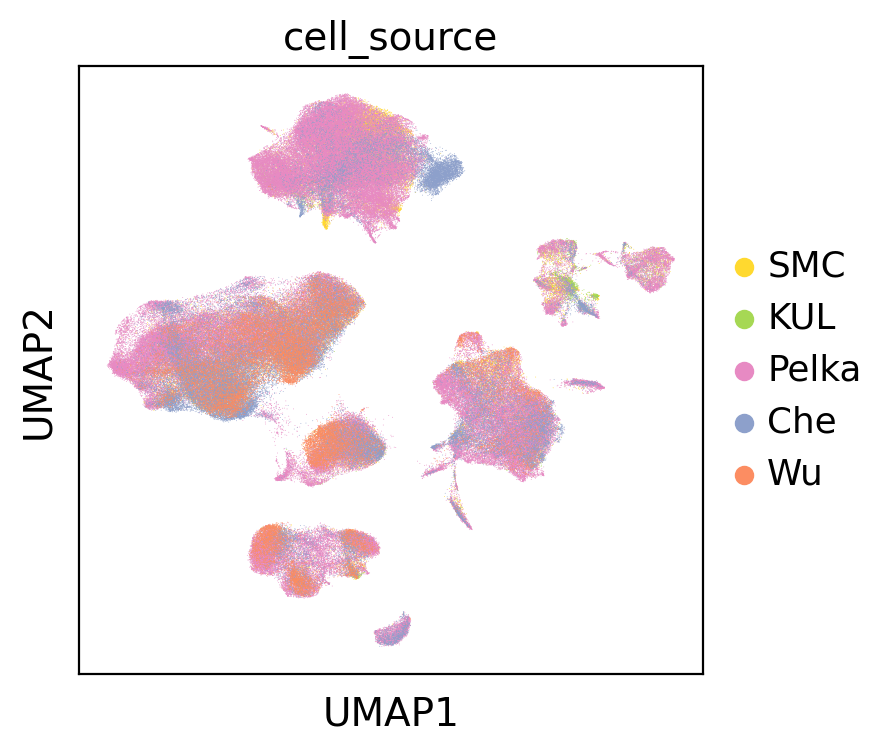

In [12]:
sc.pl.umap(adata_crc, color="cell_source", save="after_integration_scvi.pdf", show=True)

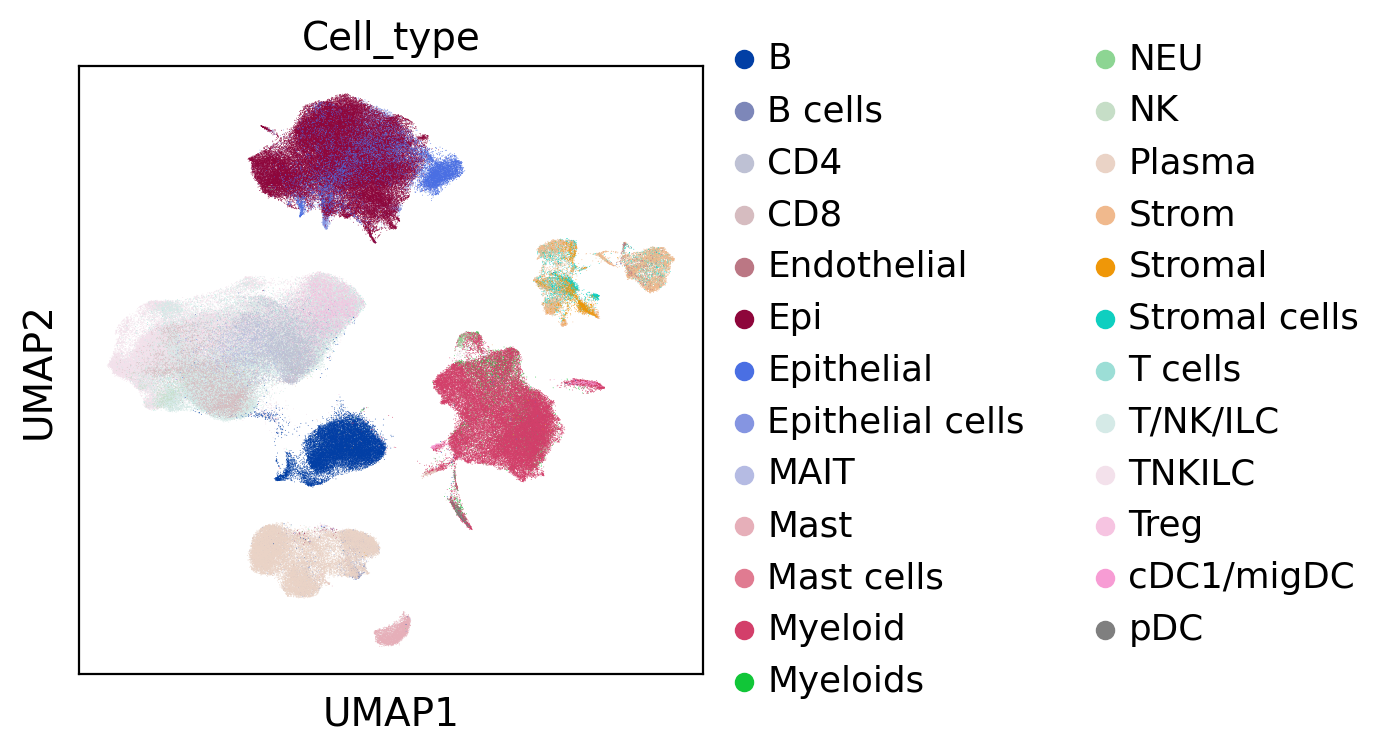

In [13]:
sc.pl.umap(adata_crc, color="Cell_type")

In [14]:
# save to file
adata_crc.write(DIR2SAVE.joinpath("SMC_KUL_Pelka_Che_Wu_CRC_integrated_scvi_hvg.h5ad"))

### change colors

In [5]:
adata_crc = sc.read_h5ad(
    DIR2SAVE.joinpath("SMC_KUL_Pelka_Che_Wu_CRC_integrated_scvi_hvg.h5ad")
)

In [6]:
# set colours for therapy
adata_crc.obs.Therapy.cat.categories

Index(['NAC', 'naive'], dtype='object')

In [7]:
adata_crc.uns["Therapy_colors"] = ["#ff7f00", "#377eb8"]

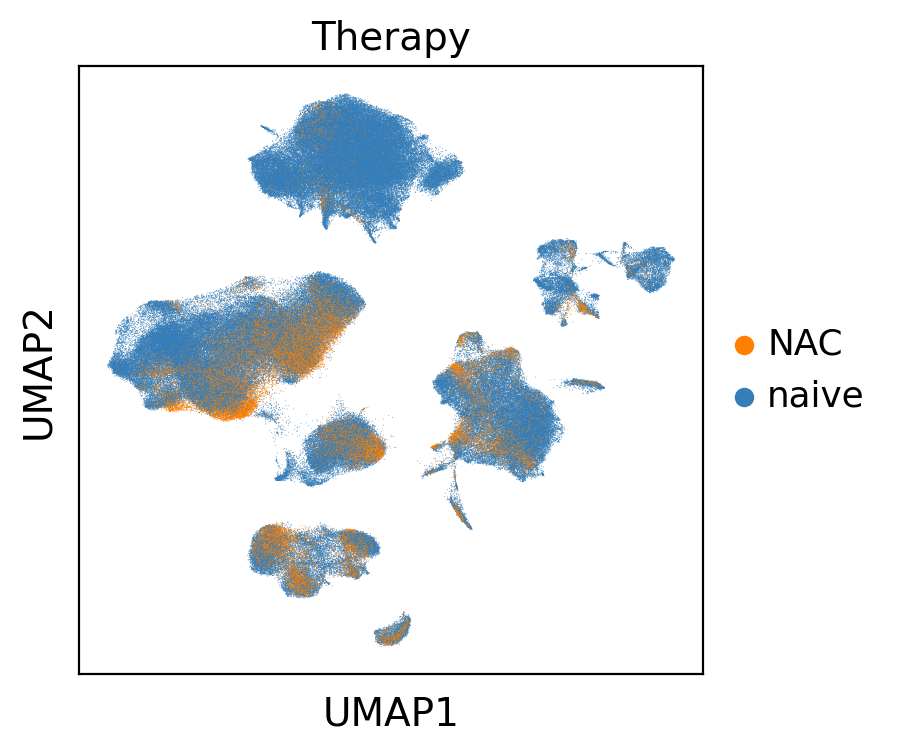

In [8]:
sc.pl.umap(adata_crc, color="Therapy", show=True, save="Therapy.pdf")

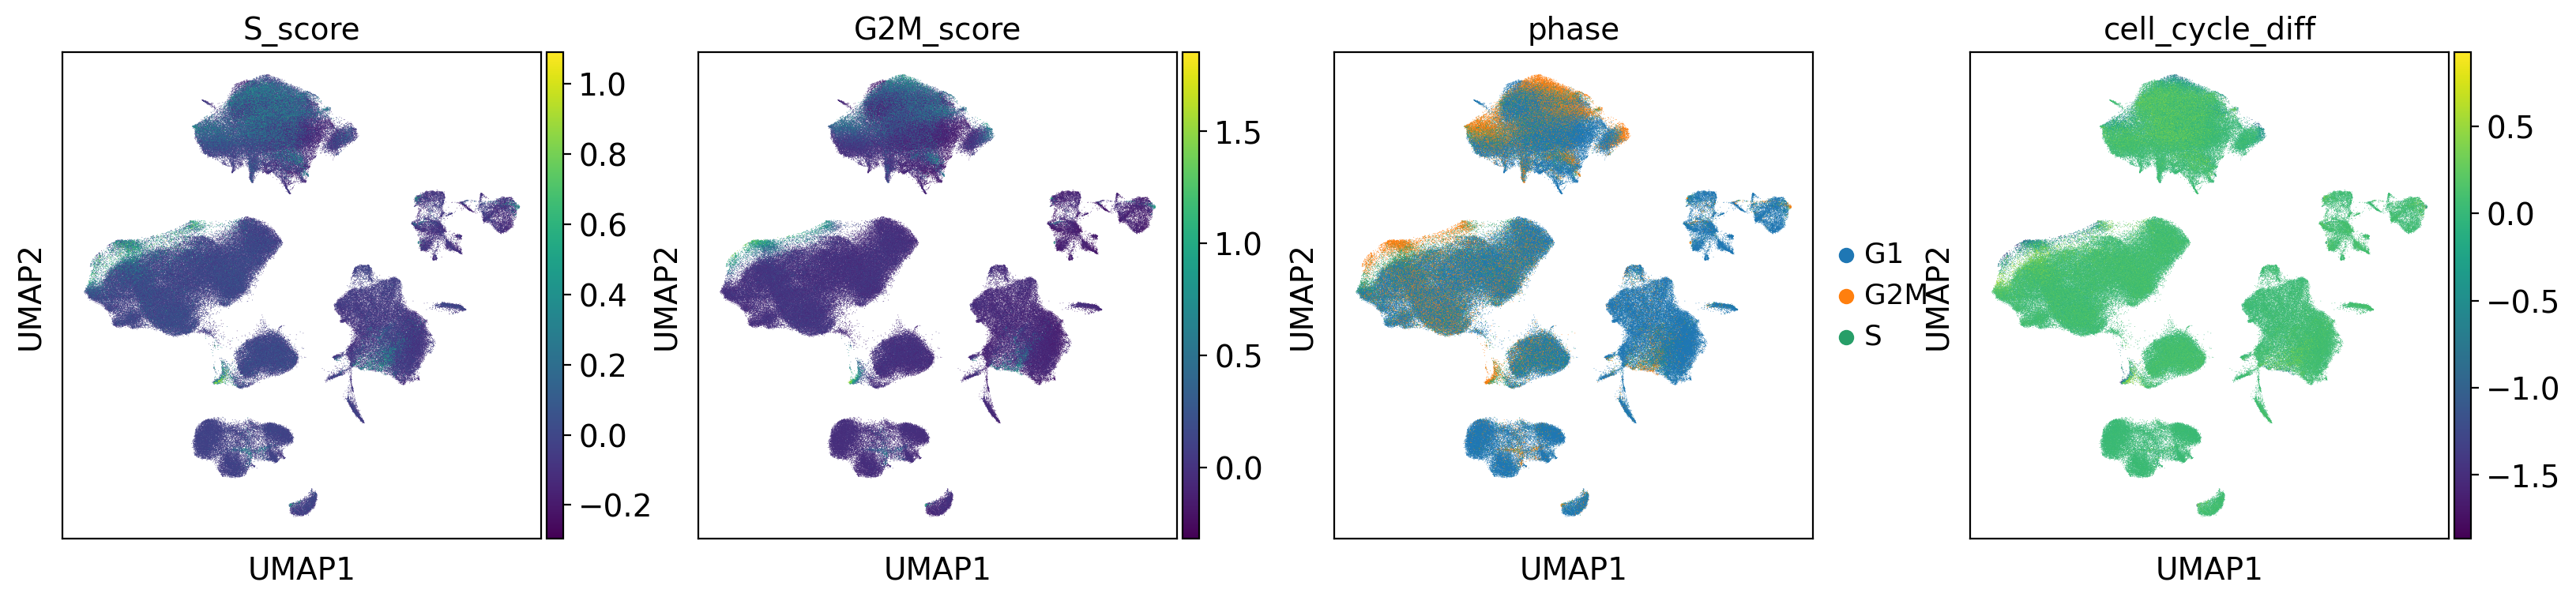

In [9]:
sc.pl.umap(
    adata_crc, color=["S_score", "G2M_score", "phase", "cell_cycle_diff"], show=True
)

In [10]:
# save to file
adata_crc.write(DIR2SAVE.joinpath("SMC_KUL_Pelka_Che_Wu_CRC_integrated_scvi_hvg.h5ad"))